In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import re
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [128]:
df = pd.read_csv('bollywood_data.csv')

In [129]:
movie_recommendation = df
movie_recommendation = movie_recommendation[movie_recommendation['year_of_release'] >= 2009]

In [130]:
#Droping columns which are not useful
df = df.drop(['title_x','title_y', 'imdb_id', 'poster_path', 'wiki_link', 'is_adult', 'tagline', 'release_date', 'story', 'summary'], axis=1)

In [131]:
#Renaming columns for ease of references
df = df.rename(columns={'original_title':'title', 'year_of_release':'year', 'imdb_rating':'rating', 'imdb_rating':'rating', 'imdb_votes':'votes', 'wins_nominations':'awards'})

In [132]:
#Data cleaning
df['awards'] = df['awards'].apply(lambda x : re.sub(r'[A-Za-z]', '', str(x)))

df[['wins', 'nominations']] = df.awards.str.split('&', expand= True)

df['wins'] = df['wins'].str.strip()
df['wins'] = df['wins'].apply(lambda x: 0 if x=='' else x)
df['wins'] = df['wins'].replace(np.nan, 0)
df['wins'] = df['wins'].astype(int)
df['nominations'] = df['nominations'].fillna(0)
df['nominations'] = df['nominations'].astype(int)

df['runtime'] = df['runtime'].replace('\\N', np.nan)
df['runtime'] = df['runtime'].ffill()
df['runtime'] = df['runtime'].astype(int)
df = df[df['runtime'] >= 60]

actors = df.actors.str.split('|', expand=True)
df['lead_actor'] = actors[0]

minor_genre_list = ['Animation', 'Documentary', 'History', 'Music', 'War', 'Sci-Fi', 'Sport']
df = df[~df['genres'].isin(minor_genre_list)]

df = df.drop(['awards','lead_actor','actors'], axis=1)
df = df[df['year'] >= 2009]
df = df.drop_duplicates()

In [133]:
df

,title,year,runtime,genres,rating,votes,budget,box office,wins,nominations
0,Uri: The Surgical Strike,2019,138,Action|Drama|War,8.4,35112,25.00,342.06,4,0
2,The Accidental Prime Minister,2019,112,Biography|Drama,6.1,5549,18.00,22.65,0,0
3,Why Cheat India,2019,121,Crime|Drama,6.0,1891,20.00,10.54,0,0
4,Evening Shadows,2018,102,Drama,7.3,280,2.75,2.50,17,1
5,Soni,2018,97,Drama,7.2,1595,0.50,0.10,3,5
...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,Action|Comedy,4.0,7266,80.00,120.00,1,3
970,Familywala,2014,180,Comedy|Drama|Romance,5.8,57,6.00,3.00,0,0
971,Sunglass,2013,100,Comedy|Drama|Thriller,6.5,24,8.00,5.00,0,0
972,Sabse Bada Sukh,2018,100,Comedy|Drama,6.1,13,10.00,7.00,0,0


In [134]:
df.shape

(966, 10)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966 entries, 0 to 973
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        966 non-null    object 
 1   year         966 non-null    int64  
 2   runtime      966 non-null    int32  
 3   genres       966 non-null    object 
 4   rating       966 non-null    float64
 5   votes        966 non-null    int64  
 6   budget       966 non-null    float64
 7   box office   966 non-null    float64
 8   wins         966 non-null    int32  
 9   nominations  966 non-null    int32  
dtypes: float64(3), int32(3), int64(2), object(2)
memory usage: 71.7+ KB


In [136]:
df.isnull().sum()

title          0
year           0
runtime        0
genres         0
rating         0
votes          0
budget         0
box office     0
wins           0
nominations    0
dtype: int64

In [137]:
df.describe()

,year,runtime,rating,votes,budget,box office,wins,nominations
count,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,2014.080745,128.213251,5.662008,6211.122153,24.957277,49.785567,2.412008,2.701863
std,2.987314,21.725897,1.586973,16031.240822,33.534848,116.259545,6.096123,7.335635
min,2009.000000,79.000000,0.000000,0.000000,0.070000,0.000800,0.000000,0.000000
25%,2012.000000,114.000000,4.600000,268.500000,5.250000,0.980000,0.000000,0.000000
50%,2014.000000,128.000000,5.700000,1371.000000,14.000000,9.920000,0.000000,0.000000
75%,2017.000000,140.000000,6.900000,5504.500000,30.000000,48.832500,2.000000,1.000000
max,2019.000000,321.000000,9.400000,310481.000000,350.000000,2100.000000,57.000000,90.000000


# Correlation

In [138]:
correlation = df.corr()
correlation

,year,runtime,rating,votes,budget,box office,wins,nominations
year,1.000000,-0.020974,0.095842,-0.023352,0.143128,0.121124,-0.067268,-0.056781
runtime,-0.020974,1.000000,0.030862,0.322493,0.420229,0.320576,0.235291,0.303413
rating,0.095842,0.030862,1.000000,0.306856,0.004809,0.183377,0.307711,0.300762
votes,-0.023352,0.322493,0.306856,1.000000,0.337135,0.574214,0.631692,0.464764
budget,0.143128,0.420229,0.004809,0.337135,1.000000,0.588761,0.284651,0.282943
box office,0.121124,0.320576,0.183377,0.574214,0.588761,1.000000,0.454525,0.364672
wins,-0.067268,0.235291,0.307711,0.631692,0.284651,0.454525,1.000000,0.685703
nominations,-0.056781,0.303413,0.300762,0.464764,0.282943,0.364672,0.685703,1.000000


<AxesSubplot:>

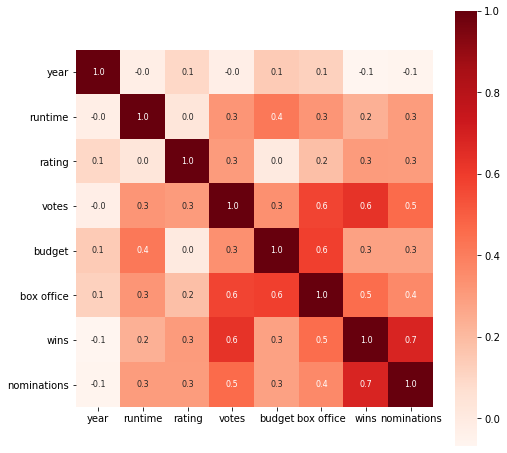

In [139]:
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Reds')

In [140]:
#correalation values of box office
print(correlation['box office'])

year           0.121124
runtime        0.320576
rating         0.183377
votes          0.574214
budget         0.588761
box office     1.000000
wins           0.454525
nominations    0.364672
Name: box office, dtype: float64


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='box office', ylabel='Density'>

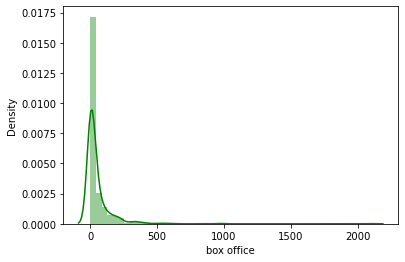

In [141]:
#checking the distribution of box office
sns.distplot(df['box office'], color='green')

# Linear Regression

In [152]:
df1 = df.loc[df['budget'].notnull()]

x = np.array(df1['budget']).reshape(-1, 1).astype(float)
y = df1['box office']

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state=0)


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((644, 1), (644,), (322, 1), (322,))

In [158]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [159]:
y_pred = regressor.predict(x_test)
print('Accuracy of linear regression classifier on test set : {:.9f} '.format(regressor.score(x_test, y_test)))

Accuracy of linear regression classifier on test set : 0.245081008 


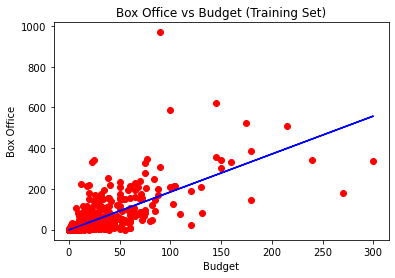

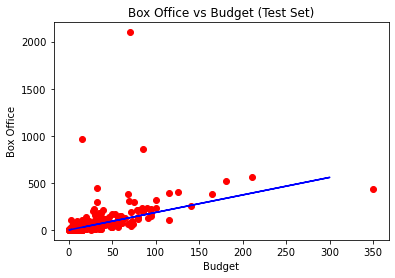

In [160]:
# Visualizing the Training set results

plt.scatter(x_train, y_train, color='red')
plt.plot(x_train, regressor.predict(x_train), color='blue')
plt.title('Box Office vs Budget (Training Set)')
plt.xlabel('Budget')
plt.ylabel('Box Office')

plt.show()

# Visualizing the Test set results

plt.scatter(x_test, y_test, color='red')
plt.plot(x_train, regressor.predict(x_train), color='blue')
plt.title('Box Office vs Budget (Test Set)')
plt.xlabel('Budget')
plt.ylabel('Box Office')

plt.show()

# Random Forest Regressor

In [21]:
X = df.drop([ 'title', 'rating', 'genres'], axis=1)
Y = df['rating']

In [22]:
print(X)

     year  runtime  votes  budget  box office  wins  nominations
0    2019      138  35112   25.00      342.06     4            0
2    2019      112   5549   18.00       22.65     0            0
3    2019      121   1891   20.00       10.54     0            0
4    2018      102    280    2.75        2.50    17            1
5    2018       97   1595    0.50        0.10     3            5
..    ...      ...    ...     ...         ...   ...          ...
969  2009      154   7266   80.00      120.00     1            3
970  2014      180     57    6.00        3.00     0            0
971  2013      100     24    8.00        5.00     0            0
972  2018      100     13   10.00        7.00     0            0
973  2019      136     38   12.00       20.00     0            0

[966 rows x 7 columns]


In [23]:
print(Y)

0      8.4
2      6.1
3      6.0
4      7.3
5      7.2
      ... 
969    4.0
970    5.8
971    6.5
972    6.1
973    7.4
Name: rating, Length: 966, dtype: float64


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [25]:
regressor = RandomForestRegressor(n_estimators=100)

In [26]:
#training the model
regressor.fit(X_train, Y_train)

RandomForestRegressor()

In [27]:
#prediction on test data
test_data_prediction = regressor.predict(X_test)

In [28]:
# R sqared error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R sqared error : ", error_score)

R sqared error :  0.39650330983405035


Compare actual values and predicted values in a plot

In [29]:
Y_test = list(Y_test)

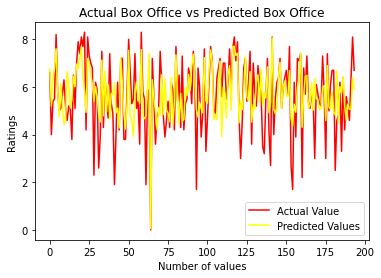

In [30]:
plt.plot(Y_test, color='red', label = 'Actual Value')
plt.plot(test_data_prediction, color='yellow', label='Predicted Values')
plt.title('Actual Box Office vs Predicted Box Office')
plt.xlabel('Number of values')
plt.ylabel('Ratings')
plt.legend()
plt.show()

# Genres Splitting

In [31]:
genres_df = pd.read_csv('bollywood_data.csv')
genres_df


,title_x,imdb_id,poster_path,wiki_link,title_y,original_title,is_adult,year_of_release,runtime,genres,imdb_rating,imdb_votes,story,summary,tagline,actors,wins_nominations,release_date,budget,box office
0,Uri: The Surgical Strike,tt8291224,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Uri:_The_Surgica...,Uri: The Surgical Strike,Uri: The Surgical Strike,0,2019,138,Action|Drama|War,8.4,35112,Divided over five chapters the film chronicles...,Indian army special forces execute a covert op...,NaN,Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...,4 wins,11 January 2019 (USA),25.00,342.06
1,Battalion 609,tt9472208,NaN,https://en.wikipedia.org/wiki/Battalion_609,Battalion 609,Battalion 609,0,2019,131,War,4.1,73,The story revolves around a cricket match betw...,The story of Battalion 609 revolves around a c...,NaN,Vicky Ahuja|Shoaib Ibrahim|Shrikant Kamat|Elen...,NaN,11 January 2019 (India),0.01,2.70
2,The Accidental Prime Minister (film),tt6986710,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/The_Accidental_P...,The Accidental Prime Minister,The Accidental Prime Minister,0,2019,112,Biography|Drama,6.1,5549,Based on the memoir by Indian policy analyst S...,Explores Manmohan Singh's tenure as the Prime ...,NaN,Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...,NaN,11 January 2019 (USA),18.00,22.65
3,Why Cheat India,tt8108208,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Why_Cheat_India,Why Cheat India,Why Cheat India,0,2019,121,Crime|Drama,6.0,1891,The movie focuses on existing malpractices in ...,The movie focuses on existing malpractices in ...,NaN,Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...,NaN,18 January 2019 (USA),20.00,10.54
4,Evening Shadows,tt6028796,NaN,https://en.wikipedia.org/wiki/Evening_Shadows,Evening Shadows,Evening Shadows,0,2018,102,Drama,7.3,280,While gay rights and marriage equality has bee...,Under the 'Evening Shadows' truth often plays ...,NaN,Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...,17 wins & 1 nomination,11 January 2019 (India),2.75,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,Samadhi (1950 film),tt0268614,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Samadhi_(1950_film),Samadhi,Samadhi,0,1950,165,Drama,6.1,21,The story is based on the true incident at INA...,The story is based on the true incident at INA...,NaN,Ashok Kumar|Nalini Jaywant|Kuldip Kaur|Shyam|M...,NaN,NaN,NaN,NaN
4325,Sangram (1950 film),tt0244182,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sangram_(1950_film),Sangram,Sangram,0,1950,139,Drama,6.2,20,After the death of his wife a policeman fails ...,After the death of his wife a policeman fails ...,NaN,Ashok Kumar|Nalini Jaywant|Nawab|Sajjan|Tiwari...,NaN,NaN,NaN,NaN
4326,Sargam (1950 film),tt0269826,NaN,https://en.wikipedia.org/wiki/Sargam_(1950_film),Melody,Sargam,0,1950,135,Drama|Family,6.8,21,NaN,Add a Plot »,NaN,Raj Kapoor|Rehana|Om Prakash|David Abraham|Rad...,NaN,4 February 1957 (Iran),NaN,NaN
4327,Sheesh Mahal (1950 film),tt0243555,https://upload.wikimedia.org/wikipedia/en/thum...,https://en.wikipedia.org/wiki/Sheesh_Mahal_(19...,Sheesh Mahal,Sheesh Mahal,0,1950,144,Drama,7.0,13,Thakur Jaspal Singh lives in the prestigious a...,Thakur Jaspal Singh lives in the prestigious a...,NaN,Sohrab Modi|Naseem Banu|Pushpa Hans|Nigar Sult...,NaN,NaN,NaN,NaN


In [32]:
#Droping columns which are not useful
genres_df = genres_df.drop(['title_x','title_y', 'imdb_id', 'poster_path', 'wiki_link', 'is_adult', 'tagline', 'release_date', 'story', 'summary'], axis=1)

In [33]:
#Renaming columns for ease of references
genres_df = genres_df.rename(columns={'original_title':'title', 'year_of_release':'year', 'imdb_rating':'rating', 'imdb_rating':'rating', 'imdb_votes':'votes', 'wins_nominations':'awards'})


In [34]:
#Data cleaning
genres_df['awards'] = genres_df['awards'].apply(lambda x : re.sub(r'[A-Za-z]', '', str(x)))

genres_df[['wins', 'nominations']] = genres_df.awards.str.split('&', expand= True)

genres_df['wins'] = genres_df['wins'].str.strip()
genres_df['wins'] = genres_df['wins'].apply(lambda x: 0 if x=='' else x)
genres_df['wins'] = genres_df['wins'].replace(np.nan, 0)
genres_df['wins'] =genres_df['wins'].astype(int)

genres_df['nominations'] = genres_df['nominations'].replace(np.nan, 0)
genres_df['nominations'] =genres_df['nominations'].astype(int)

genres_df['runtime'] = genres_df['runtime'].replace('\\N', np.nan)
genres_df['runtime'] = genres_df['runtime'].ffill()
genres_df['runtime'] = genres_df['runtime'].astype(int)
genres_df = genres_df[genres_df['runtime'] >= 60]

actors = genres_df.actors.str.split('|', expand=True)
genres_df['lead_actor'] = actors[0]

genres_df[['genre', 'genre2', 'genre3']] = genres_df.genres.str.split("|", expand=True)


minor_genre_list = ['Animation', 'Documentary', 'History', 'Music', 'War', 'Sci-Fi', 'Sport']
genres_df = genres_df[~genres_df['genre'].isin(minor_genre_list)]

genres_df = genres_df[genres_df['year'] >= 2009]
genres_df = genres_df.drop_duplicates()

In [35]:
genres_df

,title,year,runtime,genres,rating,votes,actors,awards,budget,box office,wins,nominations,lead_actor,genre,genre2,genre3
0,Uri: The Surgical Strike,2019,138,Action|Drama|War,8.4,35112,Vicky Kaushal|Paresh Rawal|Mohit Raina|Yami Ga...,4,25.00,342.06,4,0,Vicky Kaushal,Action,Drama,War
2,The Accidental Prime Minister,2019,112,Biography|Drama,6.1,5549,Anupam Kher|Akshaye Khanna|Aahana Kumra|Atul S...,,18.00,22.65,0,0,Anupam Kher,Biography,Drama,None
3,Why Cheat India,2019,121,Crime|Drama,6.0,1891,Emraan Hashmi|Shreya Dhanwanthary|Snighdadeep ...,,20.00,10.54,0,0,Emraan Hashmi,Crime,Drama,None
4,Evening Shadows,2018,102,Drama,7.3,280,Mona Ambegaonkar|Ananth Narayan Mahadevan|Deva...,17 & 1,2.75,2.50,17,1,Mona Ambegaonkar,Drama,None,None
5,Soni,2018,97,Drama,7.2,1595,Geetika Vidya Ohlyan|Saloni Batra|Vikas Shukla...,3 & 5,0.50,0.10,3,5,Geetika Vidya Ohlyan,Drama,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,Action|Comedy,4.0,7266,Mithun Chakraborty|Akshay Kumar|Deepika Paduko...,1 & 3,80.00,120.00,1,3,Mithun Chakraborty,Action,Comedy,None
970,Familywala,2014,180,Comedy|Drama|Romance,5.8,57,Arjun Rampal|Dia Mirza|Ashok Saraf|Shoma Anand...,,6.00,3.00,0,0,Arjun Rampal,Comedy,Drama,Romance
971,Sunglass,2013,100,Comedy|Drama|Thriller,6.5,24,Jaya Bachchan|Madhavan|Tota Roy Chowdhury|Raim...,,8.00,5.00,0,0,Jaya Bachchan,Comedy,Drama,Thriller
972,Sabse Bada Sukh,2018,100,Comedy|Drama,6.1,13,Vijay Arora|Asrani|Rajni Bala|Kumud Damle|Utpa...,,10.00,7.00,0,0,Vijay Arora,Comedy,Drama,None


In [36]:
genres_df = genres_df.drop([ 'awards', 'actors', 'genre2', 'genre3'], axis=1)

In [37]:
genres_df

,title,year,runtime,genres,rating,votes,budget,box office,wins,nominations,lead_actor,genre
0,Uri: The Surgical Strike,2019,138,Action|Drama|War,8.4,35112,25.00,342.06,4,0,Vicky Kaushal,Action
2,The Accidental Prime Minister,2019,112,Biography|Drama,6.1,5549,18.00,22.65,0,0,Anupam Kher,Biography
3,Why Cheat India,2019,121,Crime|Drama,6.0,1891,20.00,10.54,0,0,Emraan Hashmi,Crime
4,Evening Shadows,2018,102,Drama,7.3,280,2.75,2.50,17,1,Mona Ambegaonkar,Drama
5,Soni,2018,97,Drama,7.2,1595,0.50,0.10,3,5,Geetika Vidya Ohlyan,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,Action|Comedy,4.0,7266,80.00,120.00,1,3,Mithun Chakraborty,Action
970,Familywala,2014,180,Comedy|Drama|Romance,5.8,57,6.00,3.00,0,0,Arjun Rampal,Comedy
971,Sunglass,2013,100,Comedy|Drama|Thriller,6.5,24,8.00,5.00,0,0,Jaya Bachchan,Comedy
972,Sabse Bada Sukh,2018,100,Comedy|Drama,6.1,13,10.00,7.00,0,0,Vijay Arora,Comedy


In [38]:
Action = []
Adventure = []
Animation = []
Biography = []
Comedy = []
Crime = []
Drama = []
Family = []
Fantasy = []
History = []
Horror = []
Music = []
Musical = []
Mystery = []
Romance = []
SciFi = []
Short = []
Sport = []
Thriller = []
War = []
for row in genres_df['genres']:
    row == row.split("|")
    if 'Action' in row: 
        
        Action.append('1')
    else:
        Action.append('0')
    if 'Adventure' in row:    
        Adventure.append('1')
    else:
        Adventure.append('0')
    if 'Animation' in row:    
        Animation.append('1')
    else:
        Animation.append('0')
    if 'Biography' in row:    
        Biography.append('1')
    else:
        Biography.append('0')
    if 'Comedy' in row:    
        Comedy.append('1')
    else:
        Comedy.append('0')
    if 'Crime' in row:    
        Crime.append('1')
    else:
        Crime.append('0')
    if 'Drama' in row:    
        Drama.append('1')
    else:
        Drama.append('0')
    if 'Family' in row:    
        Family.append('1')
    else:
        Family.append('0')
    if 'Fantasy' in row:    
        Fantasy.append('1')
    else:
        Fantasy.append('0')
    if 'History' in row:    
        History.append('1')
    else:
        History.append('0')    
    if 'Horror' in row:    
        Horror.append('1')
    else:
        Horror.append('0') 
    if 'Music' in row:    
        Music.append('1')
    else:
        Music.append('0')
    if 'Musical' in row:    
        Musical.append('1')
    else:
        Musical.append('0')
    if 'Mystery' in row:    
        Mystery.append('1')
    else:
        Mystery.append('0')
    if 'Romance' in row:    
        Romance.append('1')
    else:
        Romance.append('0')
    if 'Sci-Fi' in row:    
        SciFi.append('1')
    else:
        SciFi.append('0')
    if 'Short' in row:    
        Short.append('1')
    else:
        Short.append('0')
    if 'Sport' in row:    
        Sport.append('1')
    else:
        Sport.append('0')
    if 'Thriller' in row:    
        Thriller.append('1')
    else:
        Thriller.append('0')
    if 'War' in row:    
        War.append('1')
    else:
        War.append('0')
        
genres_df["Action"] = Action
genres_df["Adventure"] = Adventure
genres_df["Animation"] = Animation
genres_df["Biography"] = Biography
genres_df["Comedy"] = Comedy
genres_df["Crime"] = Crime
genres_df["Drama"] = Drama
genres_df["Family"] = Family
genres_df["Fantasy"] = Fantasy
genres_df["History"] = History
genres_df["Horror"] = Horror
genres_df["Music"] = Music
genres_df["Musical"] = Musical
genres_df["Mystery"] = Mystery
genres_df["Romance"] = Romance
genres_df["Sci-Fi"] = SciFi
genres_df["Short"] = Short
genres_df["Sport"] = Sport
genres_df["Thriller"] = Thriller
genres_df["War"] = War

genres_df['Action'] =genres_df['Action'].astype(int)
genres_df['Adventure'] =genres_df['Adventure'].astype(int)
genres_df['Animation'] =genres_df['Animation'].astype(int)
genres_df['Biography'] =genres_df['Biography'].astype(int)
genres_df['Comedy'] =genres_df['Comedy'].astype(int)
genres_df['Crime'] =genres_df['Crime'].astype(int)
genres_df['Drama'] =genres_df['Drama'].astype(int)
genres_df['Family'] =genres_df['Family'].astype(int)
genres_df['Fantasy'] =genres_df['Fantasy'].astype(int)
genres_df['History'] =genres_df['History'].astype(int)
genres_df['Horror'] =genres_df['Horror'].astype(int)
genres_df['Music'] =genres_df['Music'].astype(int)
genres_df['Musical'] =genres_df['Musical'].astype(int)
genres_df['Mystery'] =genres_df['Mystery'].astype(int)
genres_df['Romance'] =genres_df['Romance'].astype(int)
genres_df['Sci-Fi'] =genres_df['Sci-Fi'].astype(int)
genres_df['Short'] =genres_df['Short'].astype(int)
genres_df['Sport'] =genres_df['Sport'].astype(int)
genres_df['Thriller'] =genres_df['Thriller'].astype(int)
genres_df['War'] =genres_df['War'].astype(int)
        

In [39]:
genres_df

,title,year,runtime,genres,rating,votes,budget,box office,wins,nominations,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War
0,Uri: The Surgical Strike,2019,138,Action|Drama|War,8.4,35112,25.00,342.06,4,0,...,0,0,0,0,0,0,0,0,0,1
2,The Accidental Prime Minister,2019,112,Biography|Drama,6.1,5549,18.00,22.65,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Why Cheat India,2019,121,Crime|Drama,6.0,1891,20.00,10.54,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Evening Shadows,2018,102,Drama,7.3,280,2.75,2.50,17,1,...,0,0,0,0,0,0,0,0,0,0
5,Soni,2018,97,Drama,7.2,1595,0.50,0.10,3,5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,Chandni Chowk to China,2009,154,Action|Comedy,4.0,7266,80.00,120.00,1,3,...,0,0,0,0,0,0,0,0,0,0
970,Familywala,2014,180,Comedy|Drama|Romance,5.8,57,6.00,3.00,0,0,...,0,0,0,0,1,0,0,0,0,0
971,Sunglass,2013,100,Comedy|Drama|Thriller,6.5,24,8.00,5.00,0,0,...,0,0,0,0,0,0,0,0,1,0
972,Sabse Bada Sukh,2018,100,Comedy|Drama,6.1,13,10.00,7.00,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 973
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        961 non-null    object 
 1   year         961 non-null    int64  
 2   runtime      961 non-null    int32  
 3   genres       961 non-null    object 
 4   rating       961 non-null    float64
 5   votes        961 non-null    int64  
 6   budget       961 non-null    float64
 7   box office   961 non-null    float64
 8   wins         961 non-null    int32  
 9   nominations  961 non-null    int32  
 10  lead_actor   960 non-null    object 
 11  genre        961 non-null    object 
 12  Action       961 non-null    int32  
 13  Adventure    961 non-null    int32  
 14  Animation    961 non-null    int32  
 15  Biography    961 non-null    int32  
 16  Comedy       961 non-null    int32  
 17  Crime        961 non-null    int32  
 18  Drama        961 non-null    int32  
 19  Family  

In [41]:
X = genres_df.drop([ 'title','genres', 'rating', 'lead_actor', 'genre'], axis=1)
Y = genres_df['rating']

In [42]:
X

,year,runtime,votes,budget,box office,wins,nominations,Action,Adventure,Animation,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War
0,2019,138,35112,25.00,342.06,4,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2019,112,5549,18.00,22.65,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019,121,1891,20.00,10.54,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2018,102,280,2.75,2.50,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2018,97,1595,0.50,0.10,3,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,2009,154,7266,80.00,120.00,1,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
970,2014,180,57,6.00,3.00,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
971,2013,100,24,8.00,5.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
972,2018,100,13,10.00,7.00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
Y

0      8.4
2      6.1
3      6.0
4      7.3
5      7.2
      ... 
969    4.0
970    5.8
971    6.5
972    6.1
973    7.4
Name: rating, Length: 961, dtype: float64

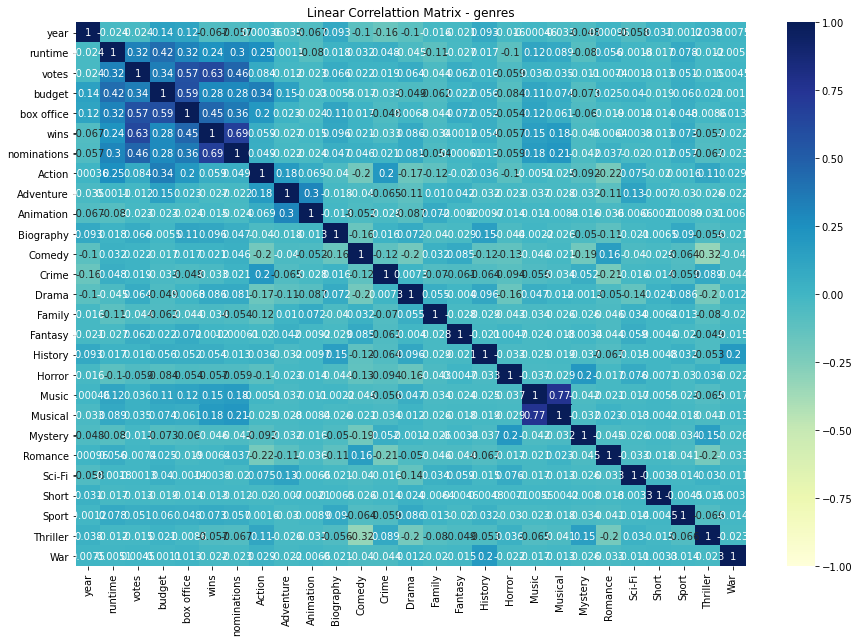

In [44]:
fit, ax = plt.subplots(figsize = (15,10))
sns.heatmap(X.corr(), annot=True, cmap='YlGnBu',vmin =- 1, vmax=1, center=0, ax=ax)
plt.title('Linear Correlattion Matrix - genres')
plt.show()

# Stepwise Regression

In [45]:
x_columns = df.drop(['title','box office','genres'], axis=1)
y = df['box office']

In [46]:
x_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966 entries, 0 to 973
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         966 non-null    int64  
 1   runtime      966 non-null    int32  
 2   rating       966 non-null    float64
 3   votes        966 non-null    int64  
 4   budget       966 non-null    float64
 5   wins         966 non-null    int32  
 6   nominations  966 non-null    int32  
dtypes: float64(2), int32(3), int64(2)
memory usage: 49.1 KB


In [47]:
## creating function to get model statistics
import numpy as np
import statsmodels.api as sm
def get_stats():
    x = x_columns
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:             box office   R-squared (uncentered):                   0.589
Model:                            OLS   Adj. R-squared (uncentered):              0.586
Method:                 Least Squares   F-statistic:                              196.4
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                   2.60e-180
Time:                        19:50:32   Log-Likelihood:                         -5616.2
No. Observations:                 966   AIC:                                  1.125e+04
Df Residuals:                     959   BIC:                                  1.128e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [48]:
x = x_columns
y = df['box office']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state=0)


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((644, 7), (644,), (322, 7), (322,))

In [49]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)


LinearRegression()

In [50]:
y_pred = regressor.predict(x_test)
print('Accuracy of linear regression classifier on test set : {:.9f} '.format(regressor.score(x_test, y_test)))

Accuracy of linear regression classifier on test set : 0.384779841 


# KNN Algorithm

KNN Algorithm (Box Office)

In [51]:
x_columns

,year,runtime,rating,votes,budget,wins,nominations
0,2019,138,8.4,35112,25.00,4,0
2,2019,112,6.1,5549,18.00,0,0
3,2019,121,6.0,1891,20.00,0,0
4,2018,102,7.3,280,2.75,17,1
5,2018,97,7.2,1595,0.50,3,5
...,...,...,...,...,...,...,...
969,2009,154,4.0,7266,80.00,1,3
970,2014,180,5.8,57,6.00,0,0
971,2013,100,6.5,24,8.00,0,0
972,2018,100,6.1,13,10.00,0,0


In [52]:
x = df.drop(['title','box office','genres'], axis=1)
y = df["box office"]
x

,year,runtime,rating,votes,budget,wins,nominations
0,2019,138,8.4,35112,25.00,4,0
2,2019,112,6.1,5549,18.00,0,0
3,2019,121,6.0,1891,20.00,0,0
4,2018,102,7.3,280,2.75,17,1
5,2018,97,7.2,1595,0.50,3,5
...,...,...,...,...,...,...,...
969,2009,154,4.0,7266,80.00,1,3
970,2014,180,5.8,57,6.00,0,0
971,2013,100,6.5,24,8.00,0,0
972,2018,100,6.1,13,10.00,0,0


In [53]:
y

0      342.06
2       22.65
3       10.54
4        2.50
5        0.10
        ...  
969    120.00
970      3.00
971      5.00
972      7.00
973     20.00
Name: box office, Length: 966, dtype: float64

In [54]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [55]:
model = KNeighborsRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
#y_pred

In [56]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = mse**(1/2)
rmse

array([94.7432952])

In [57]:
y_test.std()

107.33580195849534

KNN Algorithm (Rating)

In [58]:
x = df.drop(['title','genres','rating'], axis=1)
y = df[["rating"]]
x

,year,runtime,votes,budget,box office,wins,nominations
0,2019,138,35112,25.00,342.06,4,0
2,2019,112,5549,18.00,22.65,0,0
3,2019,121,1891,20.00,10.54,0,0
4,2018,102,280,2.75,2.50,17,1
5,2018,97,1595,0.50,0.10,3,5
...,...,...,...,...,...,...,...
969,2009,154,7266,80.00,120.00,1,3
970,2014,180,57,6.00,3.00,0,0
971,2013,100,24,8.00,5.00,0,0
972,2018,100,13,10.00,7.00,0,0


In [59]:
y

,rating
0,8.4
2,6.1
3,6.0
4,7.3
5,7.2
...,...
969,4.0
970,5.8
971,6.5
972,6.1


In [60]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [61]:
model = KNeighborsRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
#y_pred

In [62]:
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = mse**(1/2)
rmse

array([1.40209343])

In [63]:
y_test.std()

rating    1.491666
dtype: float64

# Decision Tree Regression

Decision Tree Regression (Box Office)

In [64]:
x = df.drop(['title','box office','genres'], axis=1)
y = df[["box office"]]
x

,year,runtime,rating,votes,budget,wins,nominations
0,2019,138,8.4,35112,25.00,4,0
2,2019,112,6.1,5549,18.00,0,0
3,2019,121,6.0,1891,20.00,0,0
4,2018,102,7.3,280,2.75,17,1
5,2018,97,7.2,1595,0.50,3,5
...,...,...,...,...,...,...,...
969,2009,154,4.0,7266,80.00,1,3
970,2014,180,5.8,57,6.00,0,0
971,2013,100,6.5,24,8.00,0,0
972,2018,100,6.1,13,10.00,0,0


In [65]:
y

,box office
0,342.06
2,22.65
3,10.54
4,2.50
5,0.10
...,...
969,120.00
970,3.00
971,5.00
972,7.00


In [66]:
from sklearn.tree import DecisionTreeRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6)

model = DecisionTreeRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
#y_pred

In [67]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = mse**(1/2)
rmse

array([61.40395845])

In [68]:
y_test.std()

box office    58.315506
dtype: float64

Decision Tree Regression (Rating)

In [69]:
x = df.drop(['title','rating','genres'], axis=1)
y = df[["rating"]]
x

,year,runtime,votes,budget,box office,wins,nominations
0,2019,138,35112,25.00,342.06,4,0
2,2019,112,5549,18.00,22.65,0,0
3,2019,121,1891,20.00,10.54,0,0
4,2018,102,280,2.75,2.50,17,1
5,2018,97,1595,0.50,0.10,3,5
...,...,...,...,...,...,...,...
969,2009,154,7266,80.00,120.00,1,3
970,2014,180,57,6.00,3.00,0,0
971,2013,100,24,8.00,5.00,0,0
972,2018,100,13,10.00,7.00,0,0


In [70]:
y

,rating
0,8.4
2,6.1
3,6.0
4,7.3
5,7.2
...,...
969,4.0
970,5.8
971,6.5
972,6.1


In [71]:
from sklearn.tree import DecisionTreeRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6)

model = DecisionTreeRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
#y_pred

In [72]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = mse**(1/2)
rmse

array([1.58397256])

In [73]:
y_test.std()

rating    1.516044
dtype: float64

# Logistic Regression

In [74]:
df['box_office'] = df['box office']
df = df.drop(['box office'], axis = 1)

In [75]:
df["success"] = np.where(
   (df.box_office > df.budget), 
   "1", 
   "0"
)
df['success'] = df['success'].astype(int)

In [76]:
basic_feature = ['runtime', 'budget', 'box_office', 'votes']
basic_X = df[basic_feature]
basic_y = df['success']

In [77]:
assert basic_X.shape[0] == basic_y.shape[0]
basic_X_train, basic_X_validate, basic_y_train, basic_y_validate = train_test_split(basic_X, basic_y)
basic_X_validate.shape, basic_y_validate.shape

((242, 4), (242,))

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
logres = LogisticRegression()
logres.fit(basic_X_train, basic_y_train)
logres_y_pred = logres.predict(basic_X_validate)
print('Accuracy / train:\t', cross_val_score(logres, basic_X_train, basic_y_train).mean())
print('Accuracy / validation: ', accuracy_score(logres_y_pred, basic_y_validate))

Accuracy / train:	 0.9903352490421456
Accuracy / validation:  0.987603305785124


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

# Ridge Regression

In [79]:
X  = df.drop(['box_office', 'title', 'genres'], axis=1)
y = df['box_office']

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=2)

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)

y_pred = reg.predict(test_X)

In [80]:
reg.score(test_X, test_y)

0.5274855199048709

In [81]:
reg.score(train_X, train_y)

0.5329386754859528

In [82]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)

ridge_reg.fit(train_X, train_y)

ridge_reg.score(test_X, test_y)

ridge_reg.score(train_X, train_y)

0.531639668320131

In [83]:
from sklearn.linear_model import Ridge
R = Ridge(alpha=0.0001)

In [84]:
R.fit(basic_X_train, basic_y_train)

Ridge(alpha=0.0001)

In [85]:
y_pred1 = R.predict(basic_X_validate)

In [86]:
from sklearn.metrics import r2_score
print("R2 score", r2_score(basic_y_validate, y_pred1))
print("RMSE", np.sqrt(mean_squared_error(basic_y_validate, y_pred1)))

R2 score 0.1948889725771279
RMSE 0.4478885210812475


In [87]:
x_values = train_X.sort_values(by='runtime')
x_values

,year,runtime,rating,votes,budget,wins,nominations,success
897,2010,79,3.2,209,4.0,0,0,0
516,2014,80,6.5,39,1.0,0,0,1
663,2012,82,5.5,285,0.5,1,0,0
716,2012,85,2.5,480,5.0,1,0,1
723,2012,85,6.5,67,40.0,0,0,0
...,...,...,...,...,...,...,...,...
387,2015,197,6.0,11096,30.0,0,0,0
845,2010,200,4.6,67,18.0,0,0,0
916,2009,240,3.8,41,10.0,0,0,0
693,2012,321,8.2,71636,9.2,12,43,1


In [88]:
y_values = train_X['runtime'].values.reshape(-1, 1)

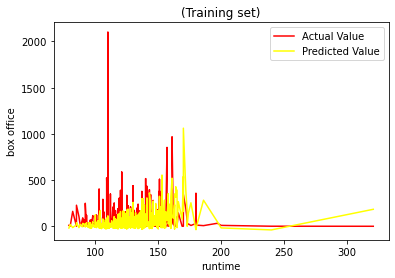

In [89]:
plt.plot(x_values['runtime'], train_y, color = "red", label = 'Actual Value')
plt.plot(x_values['runtime'], ridge_reg.predict(x_values), color = "yellow", label = 'Predicted Value')
plt.title("(Training set)")
plt.xlabel('runtime')
plt.legend()
plt.ylabel('box office')
plt.show()

# Lasso Regression

Lasso Regression (Box Office)

In [90]:
X  = df.drop(['box_office', 'title', 'genres'], axis=1)
y = df['box_office']

In [91]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=2)

In [92]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=50, max_iter=100, tol=0.1)

lasso_reg.fit(train_X, train_y)

Lasso(alpha=50, max_iter=100, tol=0.1)

In [93]:
lasso_reg.score(test_X, test_y)

0.49911513254819706

In [94]:
lasso_reg.score(train_X, train_y)

0.5064999032709836

In [95]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print("RMSE value of training data : ", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print("R2 score value of training data : ",r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print("RMSE value of testing data : ",np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print("R2 score value of testing data : ",r2_score(y_test, pred_test_lasso))

RMSE value of training data :  1.597574435379563
R2 score value of training data :  0.008064436543219866
RMSE value of testing data :  1.517216790626352
R2 score value of testing data :  -0.006737327936461535


In [96]:
x_values = train_X.sort_values(by='runtime')
x_values

,year,runtime,rating,votes,budget,wins,nominations,success
897,2010,79,3.2,209,4.0,0,0,0
516,2014,80,6.5,39,1.0,0,0,1
663,2012,82,5.5,285,0.5,1,0,0
716,2012,85,2.5,480,5.0,1,0,1
723,2012,85,6.5,67,40.0,0,0,0
...,...,...,...,...,...,...,...,...
387,2015,197,6.0,11096,30.0,0,0,0
845,2010,200,4.6,67,18.0,0,0,0
916,2009,240,3.8,41,10.0,0,0,0
693,2012,321,8.2,71636,9.2,12,43,1


In [97]:
y_values = train_X['runtime'].values.reshape(-1, 1)

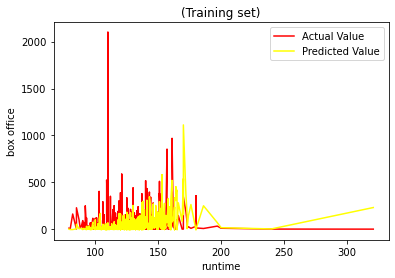

In [98]:
plt.plot(x_values['runtime'], train_y, color = "red", label = 'Actual Value')
plt.plot(x_values['runtime'], lasso_reg.predict(x_values), color = "yellow", label = 'Predicted Value')
plt.title("(Training set)")
plt.xlabel('runtime')
plt.legend()
plt.ylabel('box office')
plt.show()

Lasso Regression (Rating)

In [99]:
X  = df.drop(['rating', 'title', 'genres'], axis=1)
y = df['rating']

In [100]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=2)

In [101]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=50, max_iter=100, tol=0.1)

In [102]:
lasso_reg.fit(train_X, train_y)

Lasso(alpha=50, max_iter=100, tol=0.1)

In [103]:
lasso_reg.score(test_X, test_y)

0.0855858775989764

In [104]:
lasso_reg.score(train_X, train_y)

0.09666526307106416

In [105]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print("RMSE value of training data : ", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print("R2 score value of training data : ",r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print("RMSE value of testing data : ",np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print("R2 score value of testing data : ",r2_score(y_test, pred_test_lasso))

RMSE value of training data :  1.597574435379563
R2 score value of training data :  0.008064436543219866
RMSE value of testing data :  1.517216790626352
R2 score value of testing data :  -0.006737327936461535


# Support Vector Machine Regression

In [106]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [107]:
X = df['budget']
y = df['box_office']
X = np.array(X).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

In [108]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X = sc_x.fit_transform(X)
y = sc_y.fit_transform(y.reshape(-1,1))

In [109]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X,y)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR()

In [110]:
y_pred = regressor.predict([[8.5]])
y_pred = sc_y.inverse_transform(y_pred)

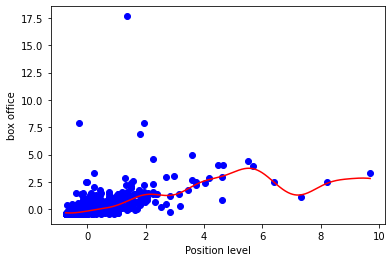

In [111]:
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color='blue')
plt.plot(X_grid, regressor.predict(X_grid), color = 'red')
plt.xlabel('Position level')
plt.ylabel('box office')
plt.show()

# Multi Label Classification

In [112]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 973
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        961 non-null    object 
 1   year         961 non-null    int64  
 2   runtime      961 non-null    int32  
 3   genres       961 non-null    object 
 4   rating       961 non-null    float64
 5   votes        961 non-null    int64  
 6   budget       961 non-null    float64
 7   box office   961 non-null    float64
 8   wins         961 non-null    int32  
 9   nominations  961 non-null    int32  
 10  lead_actor   960 non-null    object 
 11  genre        961 non-null    object 
 12  Action       961 non-null    int32  
 13  Adventure    961 non-null    int32  
 14  Animation    961 non-null    int32  
 15  Biography    961 non-null    int32  
 16  Comedy       961 non-null    int32  
 17  Crime        961 non-null    int32  
 18  Drama        961 non-null    int32  
 19  Family  

In [113]:
data = genres_df.drop(columns = ['title', 'year', 'runtime', 'genres', 'rating', 'votes', 'budget', 'box office', 'wins', 'nominations', 'lead_actor', 'genre'])
data

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
970,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
971,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
972,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
from sklearn.datasets import make_multilabel_classification

# this will generate a random multi-label dataset
X, y = make_multilabel_classification(sparse = True, n_labels = 20,
return_indicator = 'sparse', allow_unlabeled = False)

In [115]:
from sklearn.datasets import make_multilabel_classification

# this will generate a random multi-label dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [116]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.7333333333333333

In [117]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.7666666666666667

In [118]:

# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.7333333333333333

In [119]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=20)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


0.7666666666666667

# Movie Recommendation system

In [120]:
movie_recommendation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975 entries, 0 to 974
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title_x           975 non-null    object 
 1   imdb_id           975 non-null    object 
 2   poster_path       928 non-null    object 
 3   wiki_link         975 non-null    object 
 4   title_y           975 non-null    object 
 5   original_title    975 non-null    object 
 6   is_adult          975 non-null    int64  
 7   year_of_release   975 non-null    int64  
 8   runtime           975 non-null    object 
 9   genres            975 non-null    object 
 10  imdb_rating       975 non-null    float64
 11  imdb_votes        975 non-null    int64  
 12  story             964 non-null    object 
 13  summary           975 non-null    object 
 14  tagline           287 non-null    object 
 15  actors            973 non-null    object 
 16  wins_nominations  418 non-null    object 
 1

In [121]:
# we are going to use cosine similarity to find movies with similar plot
movie_recommend_df = movie_recommendation[['title_x', 'summary']]
movie_recommend_df = movie_recommend_df.dropna(subset=['summary'])
movie_recommend_df = movie_recommend_df.reset_index(level=0)
movie_recommend_df['id'] = movie_recommend_df['index']
movie_recommend_df = movie_recommend_df.drop(['index'], axis=1)

tf = TfidfVectorizer(analyzer='word', min_df=1, max_features= 200 ,stop_words='english', lowercase=True)
tfidf_matrix = tf.fit_transform(movie_recommend_df['summary'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
results = {}

for idx, row in movie_recommend_df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-50:-1]
    similar_items = [(cosine_similarities[idx][i], movie_recommend_df['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]

In [122]:
def item(id):
    return movie_recommend_df.loc[movie_recommend_df['id'] == id]['title_x']

def recommend(id, num):
    print("Recommending " + str(num) + " movie similar to " + item(id))
    recs = results[id][:num]
    i=0
    for rec in recs:
        print("We recommend : " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

In [123]:
recommend(392,3)

392    Recommending 3 movie similar to Hunterrr
Name: title_x, dtype: object
811    We recommend : Ladies vs Ricky Bahl (score:0.5...
Name: title_x, dtype: object
694    We recommend : Cocktail (2012 film) (score:0.5...
Name: title_x, dtype: object
306    We recommend : Dil Toh Deewana Hai (score:0.49...
Name: title_x, dtype: object
